### Content

### Imports 

In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_pickle('processed.pkl')

In [3]:
df.shape

(48013, 8)

#### Rejoin stemmed tweets

In [4]:
# Join the tweet back together
def rejoin_words(row):
    words = row['stemmed']
    joined_words = (" ".join(words))
    return joined_words

In [5]:
df['stemmed_joined'] = df.apply(rejoin_words, axis=1)

#### Document-Word matrix

In [6]:
vectorizer = CountVectorizer(analyzer='word',       
                             max_df=0.9, 
                             min_df=25,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

In [7]:
data_vectorized = vectorizer.fit_transform(df['stemmed_joined'])

####  Check the Sparsicity 

In [8]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", round((((data_dense > 0).sum()/data_dense.size)*100),3)*100, "%")

Sparsicity:  33.1 %


In [9]:
data_dense.shape

(48013, 2241)

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

#### Build LDA model with sklearn

In [10]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=10,           # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

In [11]:
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


#### Diagnose model performance with perplexity and log-likelihood 

In [12]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -2788830.933146764
Perplexity:  1530.1540217180452
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


#### GridSearch for the best LDA model

In [16]:
# Define Search Param
search_params = {'n_components': [4, 7, 10, 15], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

/Users/Noka/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                   

#### Best Model

In [17]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 4}
Best Log Likelihood Score:  -906094.3107418035
Model Perplexity:  1122.9426959128184


#### Compare LDA Model Performance Scores

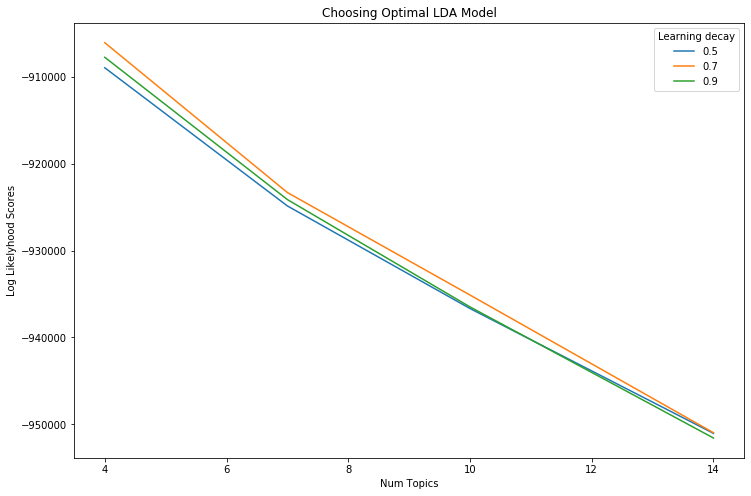

In [18]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [4, 7, 10, 14]
log_likelyhoods_5 = [round(ele) for ele in model.cv_results_['mean_test_score'][0:4]]
log_likelyhoods_7 = [round(ele) for ele in model.cv_results_['mean_test_score'][4:8]]
log_likelyhoods_9 = [round(ele) for ele in model.cv_results_['mean_test_score'][8:12]]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

#### Topic Distribution 

In [20]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Tweet " + str(i) for i in range(48013)]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,dominant_topic
Tweet 0,0.49,0.03,0.46,0.03,0
Tweet 1,0.04,0.87,0.04,0.04,1
Tweet 2,0.04,0.04,0.04,0.87,3
Tweet 3,0.04,0.04,0.74,0.18,2
Tweet 4,0.12,0.04,0.04,0.8,3
Tweet 5,0.04,0.18,0.05,0.73,3
Tweet 6,0.05,0.85,0.05,0.05,1
Tweet 7,0.05,0.86,0.05,0.04,1
Tweet 8,0.38,0.03,0.03,0.55,3
Tweet 9,0.35,0.06,0.52,0.06,2


In [21]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,3,14405
1,0,11486
2,1,11325
3,2,10797


Total Tweets 48013


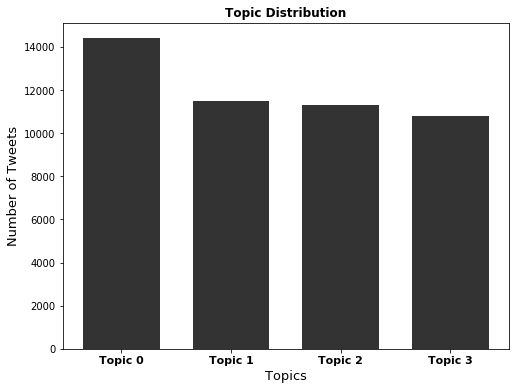

In [22]:
label = ['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3']
freq = df_topic_distribution['Num Documents']
index = np.arange(len(freq))

print("Total Tweets", df_topic_distribution['Num Documents'].sum())
plt.figure(figsize=(8,6))
plt.bar(index, freq, alpha=0.8, color= 'black', width=0.7)
plt.xlabel('Topics', fontsize=13)
plt.ylabel('Number of Tweets', fontsize=13)
plt.xticks(index, label, fontsize=11, fontweight="bold") 
plt.title('Topic Distribution', fontsize=12, fontweight="bold")
plt.show()

#### Visualize with pyLDAvis 

In [23]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/Users/Noka/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
3       7.335405 -277.268372       1        1  29.202960
1     -84.281311 -232.048615       2        1  24.350281
2     -39.064224 -140.430588       3        1  23.313174
0      52.552490 -185.650314       4        1  23.133584, topic_info=     Category         Freq       Term        Total  loglift  logprob
1104  Default  5220.000000      islam  5220.000000  30.0000  30.0000
1346  Default  2936.000000     muslim  2936.000000  29.0000  29.0000
1464  Default  2074.000000       peac  2074.000000  28.0000  28.0000
1219  Default  2109.000000       love  2109.000000  27.0000  27.0000
1727  Default  2684.000000      right  2684.000000  26.0000  26.0000
475   Default  1373.000000     cultur  1373.000000  25.0000  25.0000
332   Default  1348.000000     church  1348.000000  24.0000  24.0000
1770  Default  2681.000000        say  2681.000000  23.0000  23.0000
1636  Default  2199.000000       race  2199.000000  22.0000  22.0000
1470  Default  6578.000000      peopl  6578.000000  21.0000  21.0000
1357  Default   940.000000     nation   940.000000  20.0000  20.0000
875   Default  2370.000000       good  2370.000000  19.0000  19.0000
321   Default   874.000000      child   874.000000  18.0000  18.0000
707   Default   776.000000       evil   776.000000  17.0000  17.0000
1776  Default   760.000000     school   760.000000  16.0000  16.0000
810   Default   903.000000       forc   903.000000  15.0000  15.0000
2096  Default  1457.000000       true  1457.000000  14.0000  14.0000
747   Default  1586.000000      faith  1586.000000  13.0000  13.0000
2010  Default  1099.000000      teach  1099.000000  12.0000  12.0000
926   Default  1770.000000       hate  1770.000000  11.0000  11.0000
1143  Default  1159.000000       kill  1159.000000  10.0000  10.0000
2098  Default   865.000000      trump   865.000000   9.0000   9.0000
180   Default  1411.000000       base  1411.000000   8.0000   8.0000
197   Default  3112.000000     believ  3112.000000   7.0000   7.0000
474   Default   723.000000       cult   723.000000   6.0000   6.0000
1329  Default   654.000000      moral   654.000000   5.0000   5.0000
1151  Default  2903.000000       know  2903.000000   4.0000   4.0000
1234  Default  3095.000000       make  3095.000000   3.0000   3.0000
2052  Default  1416.000000       time  1416.000000   2.0000   2.0000
1777  Default  1177.000000     scienc  1177.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
1004   Topic4   487.608266    ideolog   638.868481   1.1937  -5.1953
2058   Topic4   262.782508      toler   322.856152   1.2580  -5.8135
64     Topic4   321.117366      allah   409.603559   1.2205  -5.6130
926    Topic4  1119.788138       hate  1770.807544   1.0056  -4.3640
1708   Topic4   606.863215    respect   922.351062   1.0453  -4.9765
1770   Topic4  1451.713012        say  2681.247856   0.8503  -4.1043
894    Topic4   288.240660       grow   388.425805   1.1656  -5.7211
1606   Topic4   245.622571    prophet   318.899193   1.2028  -5.8811
2155   Topic4   292.203872    violenc   401.768689   1.1455  -5.7074
293    Topic4   418.716582     cathol   666.118111   0.9996  -5.3477
180    Topic4   704.273426       base  1411.554691   0.7686  -4.8277
330    Topic4  1389.495235  christian  4103.298103   0.3810  -4.1482
1930   Topic4   628.284966      state  1307.354516   0.7311  -4.9419
1470   Topic4  1694.764320      peopl  6578.040507   0.1077  -3.9495
197    Topic4  1033.882907     believ  3112.210731   0.3619  -4.4438
2096   Topic4   628.768697       true  1457.896716   0.6229  -4.9411
1151   Topic4   836.875415       know  2903.519588   0.2199  -4.6552
1961   Topic4   324.156875     stupid   488.750025   1.0533  -5.6036
444    Topic4   618.194852    countri  1792.235359   0.3995  -4.9580
2040   Topic4   712.267417      think  3292.283309  -0.0670  -4.8164
803    Topic4   478.458980 

#### Topic Keywords

In [24]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,abandon,abid,abil,abl,abolish,abomin,abort,abraham,absolut,absurd,...,year,yesterday,yoga,young,youth,youtub,zealot,zionism,zionist,zuckerberg
Topic0,3.172613,21.212702,0.255616,17.724818,0.264816,2.223798,0.264882,82.649524,34.703908,27.667896,...,40.441437,0.257764,0.252081,32.439878,0.259930,19.403968,0.310672,0.255295,0.255967,37.248864
Topic1,13.604331,0.265427,0.534367,50.267043,30.208808,0.258799,19.903917,111.663128,39.234500,15.575684,...,308.815486,23.992715,49.240184,69.784411,22.235062,3.908582,0.512114,57.798560,40.812899,0.250305
Topic2,6.749878,7.801114,0.263077,50.348087,0.259364,25.248058,17.885419,41.429159,131.543370,9.415631,...,6.068744,4.477724,0.254821,42.185338,34.930350,0.262134,18.280055,0.254942,0.259576,0.250125
Topic3,39.473179,6.720758,75.946940,38.660051,0.267012,0.269345,195.945782,0.258188,101.518222,16.340789,...,413.674333,0.271797,0.252914,49.590373,0.574658,31.425316,38.897159,14.691203,9.671559,0.250706


In [27]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,islam,muslim,love,peac,peopl,say,christian,church,hate,believ,know,think,base,true,state
Topic 1,race,cultur,polit,nation,human,christian,base,time,gender,think,belief,life,woman,hindu,sexual
Topic 2,make,faith,christian,teach,peopl,child,forc,believ,use,true,thing,world,evil,good,school
Topic 3,peopl,right,know,think,good,believ,freedom,thing,say,christian,make,need,wrong,scienc,realli


#### Cluster Documents with common topic 

In [28]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=4, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.44  0.46  0.44  0.63]
 [-0.54 -0.28 -0.24  0.75]]
Perc of Variance Explained: 
 [0.01 0.37]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

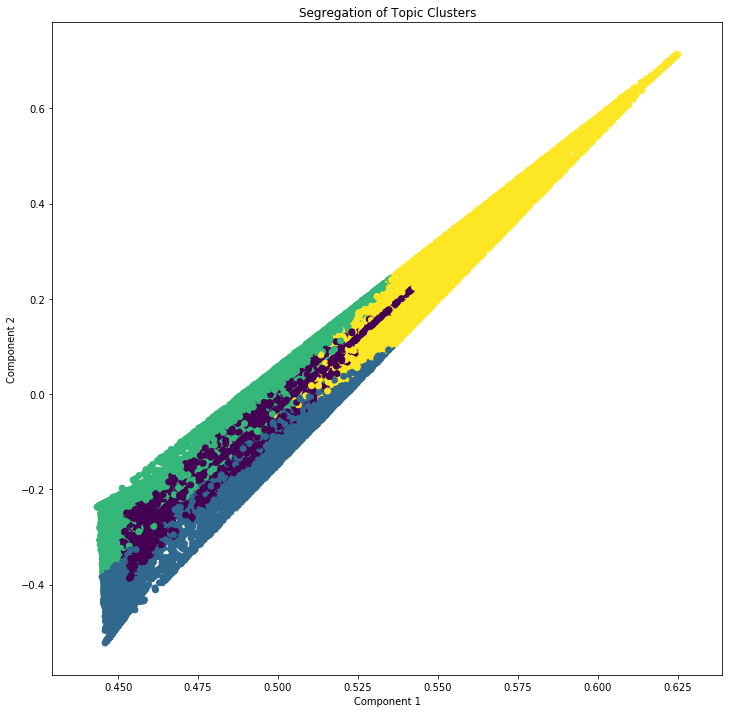

In [29]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title("Segregation of Topic Clusters", )

## END